In [2]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import ipdb
import re
from datasets import load_dataset
import os
from diversity import compression_ratio, ngram_diversity_score, extract_patterns, get_pos, pos_patterns, token_patterns, self_repetition_score
import json
from collections import Counter
from random import shuffle

tqdm.pandas()

import matplotlib.pyplot as plt
# import mplcursors
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid', context='notebook', rc={'figure.figsize':(14,10)}, font_scale=2)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('chained_assignment',None)

# Set random seeds for reproducibility on a specific machine
random.seed(1)
np.random.seed(1)
np.random.RandomState(1)
np.set_printoptions(precision=3)

In [3]:
def calc_cr_nds_sr(responses):
    cr = compression_ratio(responses, 'gzip')
    nds = ngram_diversity_score(responses, 4)
    #CR-POS
    joined_pos, tuples = get_pos(responses)
    # ngrams_pos = token_patterns(joined_pos, 5, 10)
    cr_pos = compression_ratio(joined_pos, 'gzip')
    srep = self_repetition_score(responses, verbose=False)
    return cr, cr_pos, nds, srep

def calc_diversity(df, num_shuffles=10):
    '''
    Randomly assigns personas with prompts, calculates metrics over responses for these
    pairings, then calculates mean and S.D over 10 different random pairings
    '''
    random.seed(1)
    crs = []
    ndss = []
    crs_pos = []
    sreps = []
    new_df = df.set_index(['persona_id', 'prompt_id'])
    for _ in tqdm(range(num_shuffles)):
        # Get random personas paired with every prompt
        persona_ids_shuffled = [i for i in range(100)]
        random.shuffle(persona_ids_shuffled)
        prompt_ids = [i for i in range(100)]
        pairs = list(zip(persona_ids_shuffled, prompt_ids))
        responses = new_df.loc[pairs, 'response'].values.tolist()
        
        # Calculate metrics
        cr, cr_pos, nds, srep = calc_cr_nds_sr(responses)
    
        crs.append(cr)
        ndss.append(nds)
        crs_pos.append(cr_pos)
        sreps.append(srep)
    
    print(f"CR: {np.round(np.mean(crs),2)} ± {np.round(np.std(crs),2)}\nCR-POS: {np.round(np.mean(crs_pos),2)} ± {np.round(np.std(crs_pos),2)}\nNDS: {np.round(np.mean(ndss),2)} ± {np.round(np.std(ndss),2)}\nSelf-rep:{np.round(np.mean(sreps),2)} ± {np.round(np.std(sreps),2)}")

## Dolly human responses

In [5]:
with open('../data/sample_personas.txt', 'r') as f:
    personas = [x.strip() for x in f.readlines()]
dolly = load_dataset("databricks/databricks-dolly-15k")["train"].filter(lambda row: row['category']=='creative_writing').to_pandas()
sample = pd.read_csv('../data/dolly_creative_prompts_sample.tsv', sep='\t')
sample['response'] = sample['index'].apply(lambda x: dolly.loc[x, 'response'])
sample['prompt_id'] = [i for i in range(len(sample))]
prompts = sample['instruction'].values.tolist()
human_responses = sample['response'].values.tolist()

In [5]:
cr = compression_ratio(human_responses, 'gzip')
nds = ngram_diversity_score(human_responses, 4)
joined_pos, tuples = get_pos(human_responses)
# ngrams_pos = token_patterns(joined_pos, 5, 10)
cr_pos = compression_ratio(joined_pos, 'gzip')
# rouge = homogenization_score(human_responses, 'rougel', verbose=False)
# bleu = homogenization_score(human_responses, 'bleu', verbose=False)
srep = self_repetition_score(human_responses)
# print(f"CR: {np.round(cr,2)}\nNDS: {np.round(nds,2)}\nCR-POS: {np.round(cr_pos,2)}\nHS-RougeL: {np.round(rouge,2)}\nself-bleu: {np.round(bleu,2)}\nSelf-rep: {np.round(srep, 2)}")
print(f"CR: {np.round(cr,2)}\nNDS: {np.round(nds,2)}\nCR-POS: {np.round(cr_pos,2)}\nSelf-rep: {np.round(srep, 2)}")

Calculating self-repetition score: 100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 81888.01it/s]

CR: 2.51
NDS: 3.03
CR-POS: 4.93
Self-rep: 0.55


## Llama-70B

In [6]:
# No persona, no cutoff
np70_df = pd.read_csv('../output/llama-temp0.7/llama70b-np/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
np70_df['response'] = np70_df.response.apply(lambda x: x.strip())
np70_df['prompt_id'] = [i for i in range(len(prompts))]
np70_df['persona_id'] = [-1 for i in range(len(prompts))]
cr, cr_pos, nds, srep = calc_cr_nds_sr(np70_df['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.76
CR-POS: 5.72
NDS: 2.87
Self-rep: 1.96


In [7]:
# No persona with cutoff
npc70_df = pd.read_csv('../output/llama-temp0.7/llama70b-cutoff-np/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
npc70_df['response'] = npc70_df.response.apply(lambda x: x.strip())
npc70_df['prompt_id'] = [i for i in range(len(prompts))]
npc70_df['persona_id'] = [-1 for i in range(len(prompts))]
cr, cr_pos, nds, srep = calc_cr_nds_sr(npc70_df['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.57
CR-POS: 5.1
NDS: 3.1
Self-rep: 0.44


In [9]:
persona70_df = pd.read_csv('../output/llama-temp0.7/llama70b-persona/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
persona70_df['response'] = persona70_df.response.apply(lambda x: x.strip())

if 'persona_id' not in persona70_df.columns:
    print("Adding persona prompt ids")
    persona_ids = []
    prompt_ids = []
    for persona_id in range(100):
        for prompt_id in range(100):
            persona_ids += [persona_id]
            prompt_ids += [prompt_id]
    persona70_df['prompt_id'] = prompt_ids
    persona70_df['prompt'] = persona70_df.prompt_id.apply(lambda x: prompts[x])
    persona70_df['persona_id'] = persona_ids
    persona70_df['persona'] = persona70_df.persona_id.apply(lambda x: personas[x])

persona70_df = persona70_df.drop_duplicates(subset=['prompt_id', 'persona_id'], keep='first')

calc_diversity(persona70_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.26s/it]

CR: 2.7 ± 0.01
CR-POS: 5.38 ± 0.02
NDS: 2.83 ± 0.01
Self-rep:2.6 ± 0.12


In [10]:
# Persona plus cutoff
personac70_df = pd.read_csv('../output/llama-temp0.7/llama70b-cutoff-persona/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
personac70_df['response'] = personac70_df.response.apply(lambda x: x.strip())

if 'persona_id' not in personac70_df.columns:
    print("Adding persona prompt ids")
    persona_ids = []
    prompt_ids = []
    for persona_id in range(100):
        for prompt_id in range(100):
            persona_ids += [persona_id]
            prompt_ids += [prompt_id]
    personac70_df['prompt_id'] = prompt_ids
    personac70_df['prompt'] = personac70_df.prompt_id.apply(lambda x: prompts[x])
    personac70_df['persona_id'] = persona_ids
    personac70_df['persona'] = personac70_df.persona_id.apply(lambda x: personas[x])

calc_diversity(personac70_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.48s/it]

CR: 2.51 ± 0.02
CR-POS: 5.04 ± 0.02
NDS: 3.08 ± 0.02
Self-rep:0.68 ± 0.13


In [11]:
# Persona plus cutoff plus coarse personas
persona70_df_coarse = pd.read_csv('../output/coarse/llama-cutoff-persona/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
persona70_df_coarse['response'] = persona70_df_coarse.response.apply(lambda x: x.strip())

persona70_df_coarse = persona70_df_coarse.drop_duplicates(subset=['prompt_id', 'persona_id'], keep='first')
calc_diversity(persona70_df_coarse)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.59s/it]

CR: 2.51 ± 0.02
CR-POS: 5.06 ± 0.03
NDS: 3.09 ± 0.02
Self-rep:0.59 ± 0.07


## Deepseek

In [12]:
# No persona, no cutoff
deep_npnc = pd.read_csv('../output/deepseek-np/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_npnc['response'] = deep_npnc.response.apply(lambda x: x.strip())
cr, cr_pos, nds, srep = calc_cr_nds_sr(deep_npnc['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.57
CR-POS: 5.7
NDS: 3.02
Self-rep: 1.23


In [13]:
# No persona, cutoff
deep_npc = pd.read_csv('../output/deepseek-np-cutoff/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_npc['response'] = deep_npc.response.apply(lambda x: x.strip())
cr, cr_pos, nds, srep = calc_cr_nds_sr(deep_npc['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.45
CR-POS: 5.08
NDS: 3.22
Self-rep: 0.27


In [14]:
# Persona cutoff
deep_pc = pd.read_csv('../output/deepseek-cutoff-persona/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_pc['response'] = deep_pc.response.apply(lambda x: x.strip())
deep_pc = deep_pc.drop_duplicates(subset=['prompt_id', 'persona_id'])
calc_diversity(deep_pc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.56s/it]

CR: 2.41 ± 0.02
CR-POS: 4.93 ± 0.03
NDS: 3.22 ± 0.01
Self-rep:0.32 ± 0.06


In [15]:
# Coarse persona cutoff
deep_pc_coarse = pd.read_csv('../output/coarse/deepseek-cutoff-persona/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_pc_coarse['response'] = deep_pc_coarse.response.apply(lambda x: x.strip())
deep_pc_coarse = deep_pc_coarse.drop_duplicates(subset=['prompt_id', 'persona_id'])
calc_diversity(deep_pc_coarse)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.76s/it]

CR: 2.22 ± 0.01
CR-POS: 4.78 ± 0.02
NDS: 3.37 ± 0.01
Self-rep:0.09 ± 0.04


In [27]:
deep_pc_coarse[(deep_pc_coarse.persona_id==33) & (deep_pc_coarse.prompt_id==55)]

,prompt_id,persona_id,response
3355,55,33,"Ram mimicked the speaker’s exact phrasing, including ""What's your name?"" instead of answering. This reveals the exhibit’s interactive flaw—lack of contextual understanding. In a museum setting, clear, intuitive design prevents such confusion. Instructions should differentiate between repetition and response cues, perhaps using color-coded prompts or visual indicators to guide participants appropriately. Clarity ensures engagement without misinterpretation. (58 words)"


In [26]:
deep_pc[(deep_pc.persona_id==33) & (deep_pc.prompt_id==55)]

,prompt_id,persona_id,response
3355,55,33,"Ram mimicked the speaker’s exact words, not understanding the shift from color repetition to a personal question. This illustrates a literal response without contextual comprehension—an intriguing cognitive behavior. In an exhibit, I’d use this to explore language processing, perhaps with interactive displays showing how humans and AI differentiate between rote repetition and meaningful interaction. Visual narratives would highlight the nuance of understanding context."


In [28]:
deep_npc[(deep_npc.prompt_id==55)]

,prompt_id,persona_id,response
55,55,-1,"Ram followed the pattern of repeating exact words until asked a direct question. Instead of repeating ""What's your name?"" as instructed, he answered it, breaking the repetition rule. The error lies in misunderstanding the task, as he was supposed to mimic the speaker verbatim, not respond to the question."


In [25]:
personas[33]

'a museum exhibit designer who specializes in illustrating scientific concepts through storytelling and visual narratives'

In [29]:
prompts[55]

"Ram was asked to repeat after the speaker. Speaker: Red, Ram: Red. Speaker: Blue, Ram: Blue. Speaker: Green, Ram: Green. Speaker: What's your name? , Ram: Ram\n\nWhat went wrong here?"

## Response length distribution

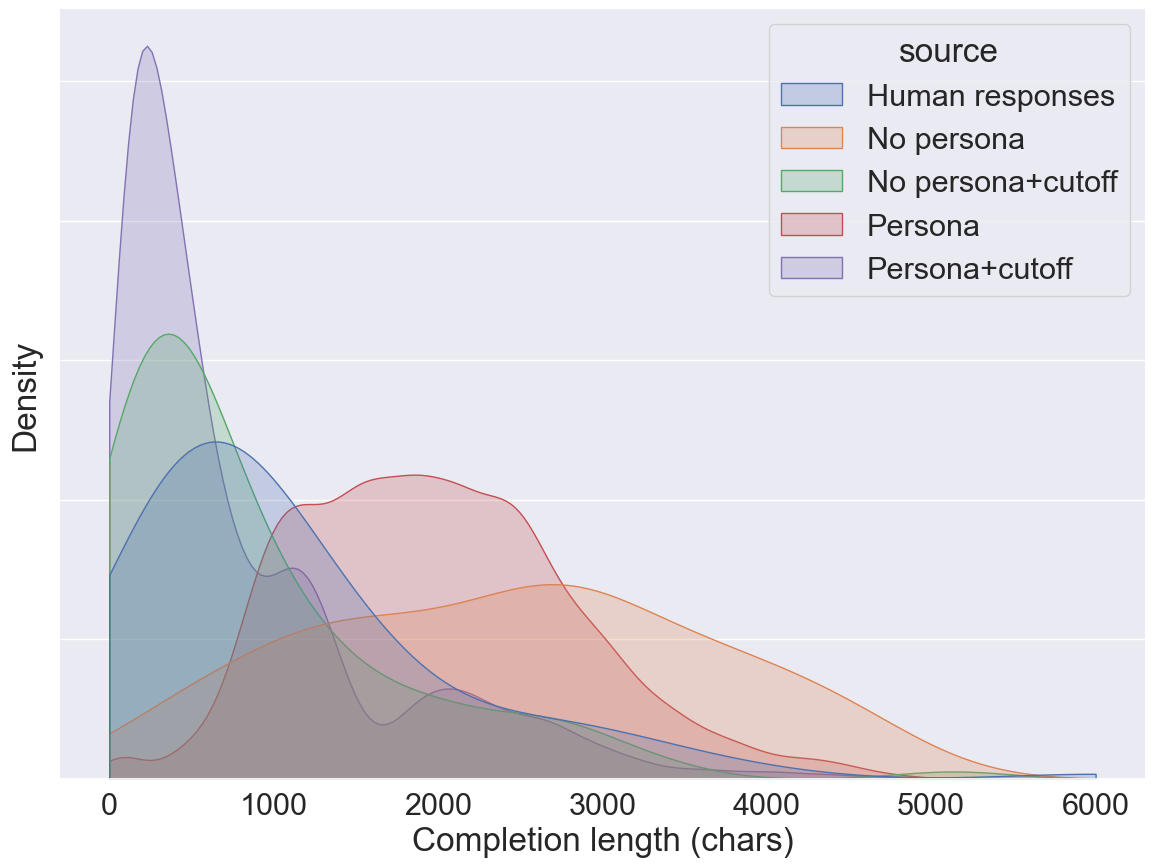

In [24]:
len_df = {'len': [], 'source':[]}

# Load all the human responses first.
len_df['len'] += sample['response'].apply(lambda x: len(x)).values.tolist()
len_df['source'] += ['Human responses' for _ in range(len(sample))]

for (df, source_name) in [(np70_df, 'No persona'), (npc70_df,'No persona+cutoff'), (persona70_df, 'Persona'), (personac70_df, 'Persona+cutoff')]:
    len_df['len'] += df['response'].apply(lambda x: len(x)).values.tolist()
    len_df['source'] += [source_name for _ in range(len(df))]
    
len_df=pd.DataFrame(len_df)

g = sns.kdeplot(len_df, x='len', hue='source', common_norm=False, fill=True, clip=[0,6000])
g.set_xlabel('Completion length (chars)')
g.set_ylabel('Density')
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
g.spines["left"].set_visible(False)
g.set(yticklabels=[])
g.grid(axis='x')
# plt.legend([], [], frameon=False)
plt.show()